In [ ]:
import tensorflow as tf
import datetime
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
from random import shuffle
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.framework import graph_util
import seaborn as sns
%matplotlib inline

In [2]:
print(f'OpenCV version: {cv2.__version__}')
print(f'Tensorflow version: {tf.__version__}')

OpenCV version: 4.1.0
Tensorflow version: 1.14.0


# PREPROCESSING

### Useful Parameters

In [3]:
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
TRAIN_DIR = 'dat'
TEST_DIR = 'data/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_PATH = f'models/{DATE}'
MODEL_NAME = 'ImageClassifier-{}.model'.format('6-conv-layer')
NUM_CLASSES = len(next(os.walk(TRAIN_DIR))[1])
DATE

'19-Oct-2019'

### Walkthrough of Subfolders in Train Directory:

In [4]:
# Only the root
ROOTS = next(os.walk(TRAIN_DIR))[0]
print(f"Roots = {ROOTS}")

Roots = data/train


In [5]:
# Only the directories
DIRS = next(os.walk(TRAIN_DIR))[1]
print(f"Dirs = {DIRS}")

Dirs = ['Allie Haze', 'Ariel X', 'Ariella Ferrera', 'Mellanie Monroe', 'Samantha Ryan', 'Tanya Tate']


In [6]:
# Only the files
for root, dirs, files in os.walk(TRAIN_DIR):
    for name in files:
        print(name.split('.')[0]) # filters the file name by file extension and the copy_number
        

Allie Haze (1)
Allie Haze (10)
Allie Haze (11)
Allie Haze (12)
Allie Haze (13)
Allie Haze (14)
Allie Haze (15)
Allie Haze (16)
Allie Haze (17)
Allie Haze (18)
Allie Haze (19)
Allie Haze (2)
Allie Haze (20)
Allie Haze (21)
Allie Haze (22)
Allie Haze (23)
Allie Haze (24)
Allie Haze (25)
Allie Haze (26)
Allie Haze (27)
Allie Haze (28)
Allie Haze (29)
Allie Haze (3)
Allie Haze (30)
Allie Haze (31)
Allie Haze (32)
Allie Haze (33)
Allie Haze (34)
Allie Haze (35)
Allie Haze (36)
Allie Haze (37)
Allie Haze (38)
Allie Haze (39)
Allie Haze (4)
Allie Haze (40)
Allie Haze (41)
Allie Haze (42)
Allie Haze (43)
Allie Haze (44)
Allie Haze (45)
Allie Haze (46)
Allie Haze (47)
Allie Haze (48)
Allie Haze (49)
Allie Haze (5)
Allie Haze (50)
Allie Haze (51)
Allie Haze (52)
Allie Haze (53)
Allie Haze (54)
Allie Haze (55)
Allie Haze (56)
Allie Haze (57)
Allie Haze (58)
Allie Haze (59)
Allie Haze (6)
Allie Haze (60)
Allie Haze (61)
Allie Haze (62)
Allie Haze (63)
Allie Haze (64)
Allie Haze (65)
Allie Haze (66

### Generation of Image classes

In [7]:
# Used for abbreviating the class names NOT USED

"""def get_class_labels():
    labels = []
    for root, dirs, files in os.walk(TRAIN_DIR):
        path = root.split(os.sep)
        for subfolder in dirs:
            name = subfolder.split()
            class_label = "".join([letter[0] for letter in name])
            labels.append(class_label)
    return labels"""

'def get_class_labels():\n    labels = []\n    for root, dirs, files in os.walk(TRAIN_DIR):\n        path = root.split(os.sep)\n        for subfolder in dirs:\n            name = subfolder.split()\n            class_label = "".join([letter[0] for letter in name])\n            labels.append(class_label)\n    return labels'

### One-Hot Encoding

In [8]:
LABELS = next(os.walk(TRAIN_DIR))[1] # all the class labels (pornstar names) to be used
LABELS = np.reshape(LABELS, (-1, 1)) # reshapes array from 1D to 2D array
mlb = MultiLabelBinarizer()
encoded_labels = np.array(mlb.fit_transform(LABELS))

In [9]:
dict(zip(LABELS.flatten(), encoded_labels))

{'Allie Haze': array([1, 0, 0, 0, 0, 0]),
 'Ariel X': array([0, 1, 0, 0, 0, 0]),
 'Ariella Ferrera': array([0, 0, 1, 0, 0, 0]),
 'Mellanie Monroe': array([0, 0, 0, 1, 0, 0]),
 'Samantha Ryan': array([0, 0, 0, 0, 1, 0]),
 'Tanya Tate': array([0, 0, 0, 0, 0, 1])}

In [10]:
"""
Labelled training data
"""
def create_train_data():
    training_data = []
    # iterate over each image-class (subfolder) in training directory
    for folder in tqdm(os.listdir(TRAIN_DIR)):
        full_path = f'{TRAIN_DIR}/{folder}'
        # iterate over each image in each subfolder
        for img in os.listdir(full_path):
            img_name = img.split('.')[0].split('(')[0]  # filters the file name by file extension and the copy_number
            img_name = img_name.strip() # removes any leading and trailing whitespaces from the img name
            label = mlb.transform([[img_name]]) # encodes the label of the image using MultiLabelBinarizer
            label = label.flatten()  # converts encoded label from 2D to 1D array
            # print(f'Image: {img} - Encoding:{label}')
            path = os.path.join(full_path, img)  # full path of the image
            # feature extraction
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [11]:
"""
Unlabelled test data
"""
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [12]:
# train_data = create_train_data()
# test_data = process_test_data()
# if train/test data already exists
train_data = np.load('train_data.npy', allow_pickle=True)
test_data = np.load('test_data.npy', allow_pickle=True)

# BUILDING THE MODEL

### Implementation of Convoluted Neural Network

In [13]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

def create_cnn_model():
    tf.reset_default_graph()

    # INPUT_LAYER
    convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

    # HIDDEN_LAYER_1
    convnet = conv_2d(convnet, 32, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # HIDDEN_LAYER_2
    convnet = conv_2d(convnet, 64, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # HIDDEN_LAYER_3
    convnet = conv_2d(convnet, 128, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # HIDDEN_LAYER_4
    convnet = conv_2d(convnet, 32, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # HIDDEN_LAYER_5
    convnet = conv_2d(convnet, 64, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # HIDDEN_LAYER_6
    convnet = conv_2d(convnet, 128, 6, activation='relu')
    convnet = max_pool_2d(convnet, 6)

    # FULLY_CONNECTED_LAYER
    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = dropout(convnet, 0.8)

    # OUTPUT LAYER
    convnet = fully_connected(convnet, NUM_CLASSES, activation='softmax')
    convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

    model = tflearn.DNN(convnet, tensorboard_dir='log')
    return convnet, model 

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


W1019 16:03:03.908814 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\helpers\summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W1019 16:03:03.912804 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\helpers\trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W1019 16:03:03.938735 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W1019 16:03:03.955692 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W1019 16:03:03.978630 16220 deprecation_wrappe

In [14]:
CONVNET, MODEL = create_cnn_model()
if os.path.exists(f'{MODEL_PATH}/{MODEL_NAME}.meta'):
    MODEL.load(f'{MODEL_PATH}/{MODEL_NAME}')
    print('model loaded!')

W1019 16:03:04.004656 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\layers\core.py:81: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1019 16:03:04.009546 16220 deprecation.py:506] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tflearn\initializations.py:119: calling UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1019 16:03:04.011540 16220 deprecation.py:323] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=

# TRAINING THE NETWORK

In [15]:
train = train_data[:-100] # sample train data
test = train_data[-100:]

### Frequency distribution of classes being used in "test data"

In [16]:
enc = []
for img in test:
    enc.append(img[1])
    
enc = np.array(enc)
test_labels = mlb.inverse_transform(enc)
c = Counter(test_labels)
c

Counter({('Ariella Ferrera',): 20,
         ('Ariel X',): 21,
         ('Mellanie Monroe',): 18,
         ('Allie Haze',): 15,
         ('Samantha Ryan',): 9,
         ('Tanya Tate',): 17})

In [17]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_Y = [i[1] for i in test]

In [18]:
MODEL.fit({'input': X}, {'targets': Y}, n_epoch=100, validation_set=({'input': test_X}, {'targets': test_Y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 699  | total loss: 0.66162 | time: 1.888s
| Adam | epoch: 100 | loss: 0.66162 - acc: 0.9246 -- iter: 384/423
Training Step: 700  | total loss: 0.59645 | time: 3.119s
| Adam | epoch: 100 | loss: 0.59645 - acc: 0.9321 | val_loss: 0.84504 - val_acc: 0.8100 -- iter: 423/423
--


In [19]:
with CONVNET.graph.as_default():
    del tf.get_collection_ref(tf.GraphKeys.TRAIN_OPS)[:]  # gets rid of all useless training attributes in the model graph
MODEL.save(f'{MODEL_PATH}/{MODEL_NAME}')

### Convert model to TensorFlow Lite format

In [20]:
%run freeze_model.py

W1019 16:08:45.956427 16220 deprecation_wrapper.py:119] From C:\Users\chiso\Google Drive Developer\Humandroid\Workspace\freeze_model.py:18: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W1019 16:08:46.561808 16220 deprecation.py:323] From C:\Users\chiso\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W1019 16:08:46.753294 16220 deprecation.py:323] From C:\Users\chiso\Google Drive Developer\Humandroid\Workspace\freeze_model.py:23: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W1019 16:08:46.757285 16

Graph successfully frozen!
File: 'frozen_model.pb' created successfully!


In [21]:
filename = 'tensorboard_nodes.txt'
gf = tf.GraphDef()   
m_file = open('frozen_model.pb','rb')
gf.ParseFromString(m_file.read())

open(filename, "w").close() # clears prev file contents
with open(filename, 'a') as file:
    for n in gf.node:
        file.write(f'{n.name} \n')

file = open(filename,'r')
data = file.readlines()
print("output name = ")
print(data[len(data)-1])

print("Input name = ")
file.seek(0)
print(file.readline())
file.close()

output name = 
FullyConnected_1/Softmax 

Input name = 
input/X 



In [22]:
"""converter = tf.lite.TFLiteConverter.from_frozen_graph('frozen_model.pb', ['input/X'], ['FullyConnected_1/Softmax'])
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)"""

'converter = tf.lite.TFLiteConverter.from_frozen_graph(\'frozen_model.pb\', [\'input/X\'], [\'FullyConnected_1/Softmax\'])\ntflite_model = converter.convert()\nopen("converted_model.tflite", "wb").write(tflite_model)'

# RESULTS

In [23]:
CLASS_INDEX = dict(zip([np.argmax(x) for x in encoded_labels], LABELS.flatten()))
# CLASS_INDEX = dict(sorted(CLASS_INDEX.items()))
LABELS = LABELS.flatten()
IMAGE_IDs = []
CLASS_INDEX

{0: 'Allie Haze',
 1: 'Ariel X',
 2: 'Ariella Ferrera',
 3: 'Mellanie Monroe',
 4: 'Samantha Ryan',
 5: 'Tanya Tate'}

### Graph Plot of Predicted Classes

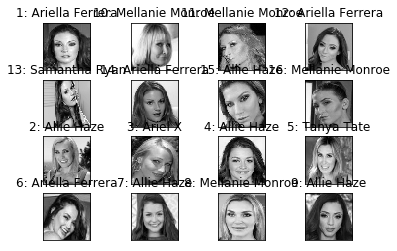

<Figure size 432x288 with 0 Axes>

In [24]:
fig = plt.figure()
results = {cls: [] for cls in LABELS}

# iterate over each image in test_sample
# get the model's class prediction of the image
for num, data in enumerate(test_data):
    img_data = data[0]
    img_num = data[1]
    y = fig.add_subplot(4, 4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = MODEL.predict([data])[0]
    index = np.argmax(model_out)

    # generate output dictionary
    results = {LABELS[i]: results.get(LABELS[i]) + [model_out[i]] for i in range(NUM_CLASSES)}
    IMAGE_IDs.append(img_num)
    
    # cross-reference the predicted class-index to its class-label (for each test image)
    class_label = CLASS_INDEX.get(index, 'Invalid class!')
    # print(f"Image ID: {img_num} | \tModel Output: {model_out}  \t | Prediction: {index}")

    y.imshow(orig, cmap='gray')
    plt.title(f'{img_num}: {class_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
plt.savefig('Class Results')

### Tabulated Prediction Probabilities

In [25]:
# Creates a HeatMap using the seaborn library
cm = sns.light_palette("purple", as_cmap=True)
df = pd.DataFrame.from_dict(results, orient='index', columns=['Image '+ str(i) for i in IMAGE_IDs])
df.style.\
    format("{:.2%}").\
    set_caption('Confidence Values')\
    .background_gradient(cmap=cm)

,Image 1,Image 10,Image 11,Image 12,Image 13,Image 14,Image 15,Image 16,Image 2,Image 3,Image 4,Image 5,Image 6,Image 7,Image 8,Image 9
Allie Haze,13.86%,0.04%,1.41%,9.78%,0.22%,15.70%,94.73%,1.83%,41.56%,0.77%,84.20%,15.55%,8.50%,97.12%,0.34%,91.15%
Ariel X,2.69%,0.52%,1.54%,2.46%,0.13%,1.64%,0.37%,1.01%,10.87%,91.49%,3.24%,6.62%,1.38%,0.42%,41.65%,1.26%
Ariella Ferrera,70.23%,0.18%,2.26%,60.93%,1.69%,77.74%,0.61%,2.31%,4.91%,0.93%,5.47%,9.20%,81.55%,0.67%,1.12%,4.88%
Mellanie Monroe,2.78%,99.19%,91.20%,3.42%,0.16%,1.22%,2.88%,89.04%,34.16%,6.13%,2.31%,12.05%,1.68%,0.85%,56.49%,0.75%
Samantha Ryan,5.86%,0.00%,0.23%,18.20%,97.26%,1.17%,0.18%,0.24%,3.63%,0.32%,2.04%,5.17%,3.90%,0.19%,0.06%,0.74%
Tanya Tate,4.58%,0.06%,3.37%,5.23%,0.54%,2.54%,1.23%,5.58%,4.88%,0.36%,2.74%,51.41%,3.00%,0.76%,0.34%,1.21%


In [26]:
"""
Re-structures the results dictionary so that each class_label points to another dictionary {k, v}
where k = the Image_Id number and v = the confidence value
"""

def gen_results(results):
    my_dict = {}
    for cls in LABELS:
        probs = iter(results[cls])
        my_dict.update({cls: {}})
        for k in IMAGE_IDs:
            my_dict[cls][int(k)] = next(probs)

    return my_dict

In [27]:
def get_top3(results, ID=1):
    results = gen_results(results)
    probs = np.array([(results[k][ID]) for k in results])
    # print(f'Reverse: {(-probs).argsort()} - {sorted(probs, reverse=True)}')
    indices = (-probs).argsort()[:3] # sorts probabilities (largest - smallest) + returns their corresponding array indices
    top_3 = [CLASS_INDEX.get(index) for index in indices]
    return top_3

In [28]:
Image_ID = 5
TOP_3 = get_top3(results, Image_ID)
TOP_3

['Tanya Tate', 'Allie Haze', 'Mellanie Monroe']

# TENSORBOARD

In [ ]:
!tensorboard --logdir=foo:"C:\Users\chiso\Google Drive Developer\Humandroid\Workspace\log"